# Visualizations for the introduction to the project

In [6]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import geodata

In [2]:
#All of the below choropleth map visualisations can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
statesToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(statesToRemove)]
geoData['county_fips'] = geoData['STATE'] + geoData['COUNTY']


## Well Level Visualization

Average yearly water level changes for wells measured within each county.

In [21]:
trends = pd.read_csv('final_without_totals.csv')

#fix fips code if csv import causes them to drop leading 0
trends = trends.dropna(subset = ['county_fips'])
trends['county_fips'] = trends['county_fips'].astype(int)
trends['county_fips'] = trends['county_fips'].astype(str)
for i, row in trends.iterrows():
    fips = row['county_fips']
    if len(fips)== 4:
        trends.loc[i, 'county_fips'] = '0' + fips

In [22]:
trends_viz_dict = {}
for county in trends['county_fips'].unique():
    county_df = trends[trends['county_fips'] == county]
    county_df = county_df.reset_index()
    
    decadal_change_mean = county_df['decadal_change'].mean() *-1
    decadal_change_median = county_df['decadal_change'].median() *-1
    slope_mean = county_df['slope'].mean() *-1
    slope_median = county_df['slope'].median()*-1
    
    trends_viz_dict[county] = {'county_fips': county,  'decade_change_mean': decadal_change_mean, 
                          'decade_change_median': decadal_change_median, 'slope_mean': slope_mean, 
                          'slope_median': slope_median#,'county_name': name
                         }
trends_viz_df = pd.DataFrame(trends_viz_dict).T  
viz_df = geoData.merge(trends_viz_df, how = 'left', on = 'county_fips')

<GeoAxes: title={'center': 'Water Level Change in Feet/Year: \nMean Change in Wells per County'}>

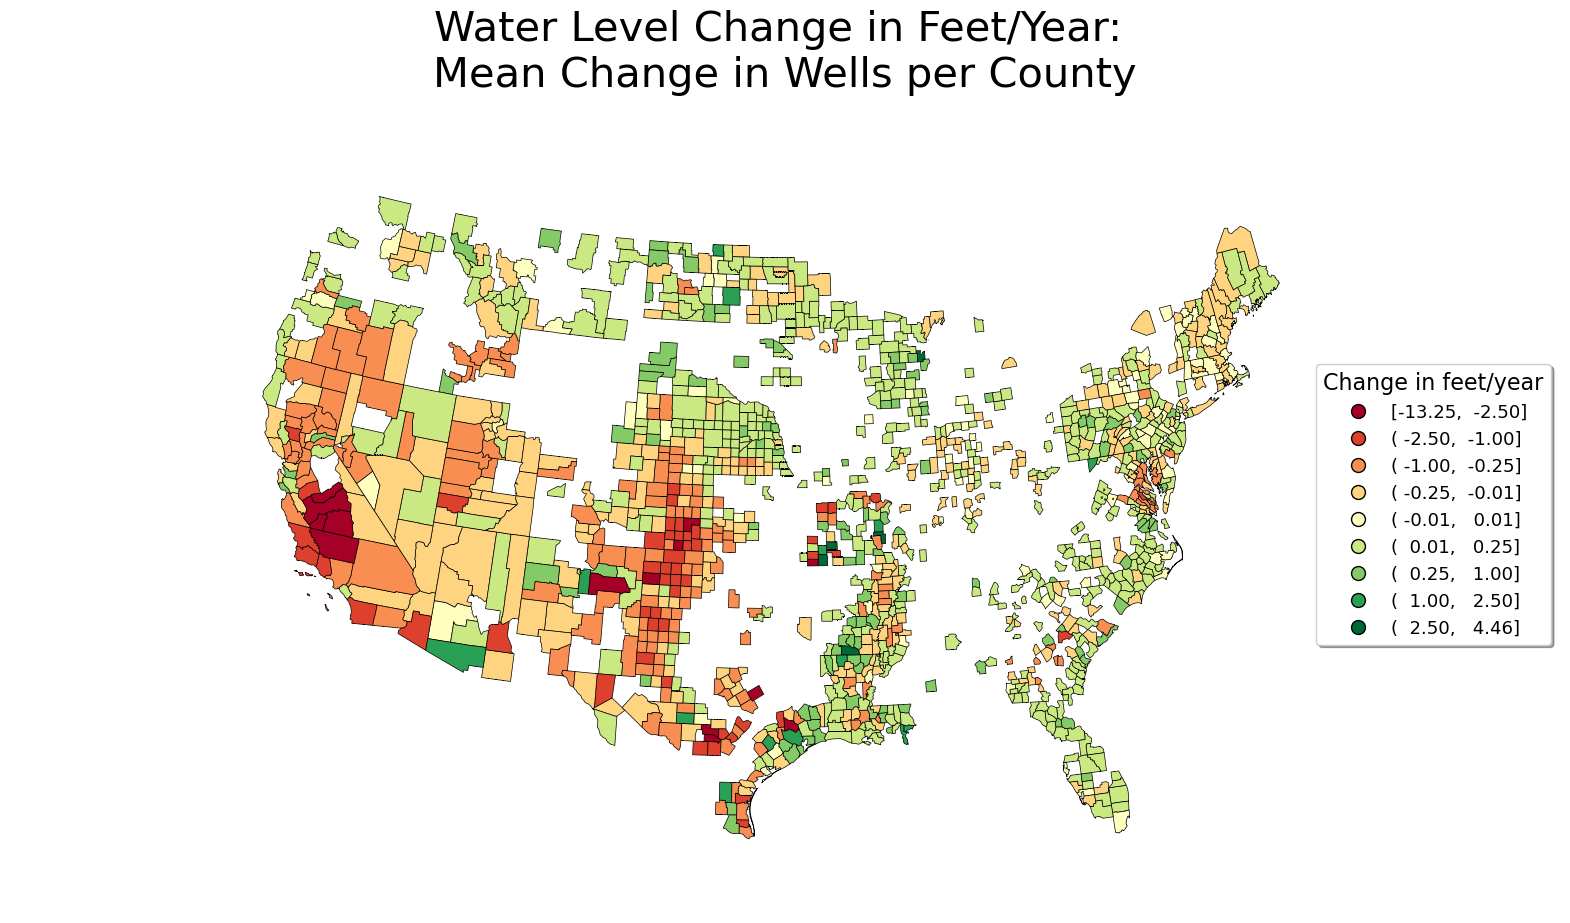

In [23]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df.dropna(subset =['slope_mean'])
scheme = mc.UserDefined(viz_df['slope_mean'], bins=[-2.5, -1, -.25, -.01, .01, .25, 1, 2.5])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="slope_mean",
    scheme=scheme, 
    cmap='RdYlGn',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = True,
    legend_kwargs={'loc': 'center right', 'title': 'Change in feet/year', 'shadow': True, 'title_fontsize': 16, 'fontsize':13}
)


count = 0
for txt in plot1.get_legend().texts:
    txt.set_text(mapping[count])
    count +=1
title = 'Water Level Change in Feet/Year: \nMean Change in Wells per County'
plot1.axes.set_title(title, fontsize=30)
plot1

## Water Use Visualizations

In [24]:
df = pd.read_csv('usco2015v2.0.csv')
df.columns = df.iloc[0]
df = df[1:]
df = df[df['STATEFIPS'].astype(int)<70]
focus = ['PS-WFrTo', 'DO-WFrTo','IN-WFrTo', 'IR-WFrTo', 'LI-WFrTo', 'AQ-WFrTo', 'MI-WFrTo', 'PT-WFrTo']
df_focus = df[focus]

In [25]:
df_focus = df_focus.replace('--', 0)
df_focus = df_focus.astype(float)
df_focus=df_focus.fillna(0).sum().to_frame().rename(columns = {0: 'Mega Gallons/day'}).reset_index().rename(columns = {0: 'domain'})
df_focus = df_focus.sort_values(by='Mega Gallons/day', ascending=False)

C:\Users\mattp\AppData\Local\Temp\ipykernel_33300\4139403273.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(['Irrigation', 'Thermoelectric', "Public Supply", 'Industry', 'Aquaculture', 'Domestic', 'Livestock', 'Mining'], rotation=45, fontsize=10, ha = 'right')


Text(0.5, 1.0, 'Self-Supplied Freshwater Withdrawals per Domain: \nUnited States 2015')

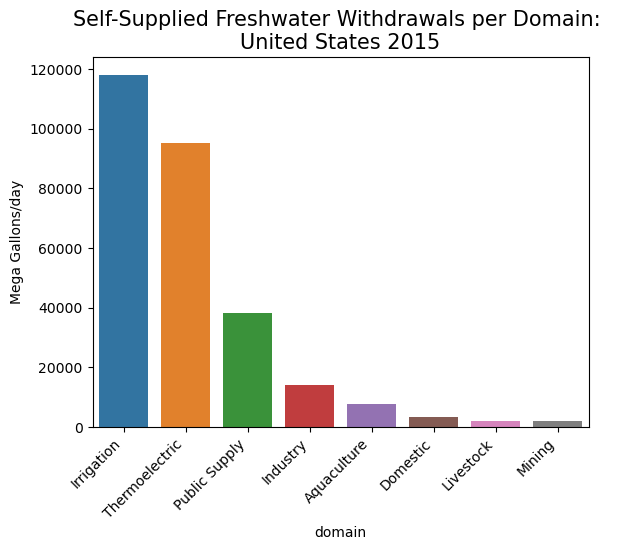

In [26]:
plot = sns.barplot(df_focus, x="domain", y="Mega Gallons/day", hue="domain")
plot.set_xticklabels(['Irrigation', 'Thermoelectric', "Public Supply", 'Industry', 'Aquaculture', 'Domestic', 'Livestock', 'Mining'], rotation=45, fontsize=10, ha = 'right')

plot.set_title('Self-Supplied Freshwater Withdrawals per Domain: \nUnited States 2015', fontsize=15)

#### Water-Use Choropleths

In [11]:
water_2015 = pd.read_csv('usco2015v2.0.csv')
water_2015.columns = water_2015.iloc[0]
water_2015 = water_2015[1:]
water_2015 = water_2015[water_2015['STATEFIPS'].astype(int)<70]
water_2015.rename(columns = {'FIPS': 'county_fips'}, inplace = True)
viz_df_full = geoData.merge(water_2015, how = 'left', on = 'county_fips')

Domestic Water Use

C:\Users\mattp\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<GeoAxes: title={'center': 'Publicly Supplied Water Delivered \nto Homes for Domestic Use: \n2015 values per county'}>

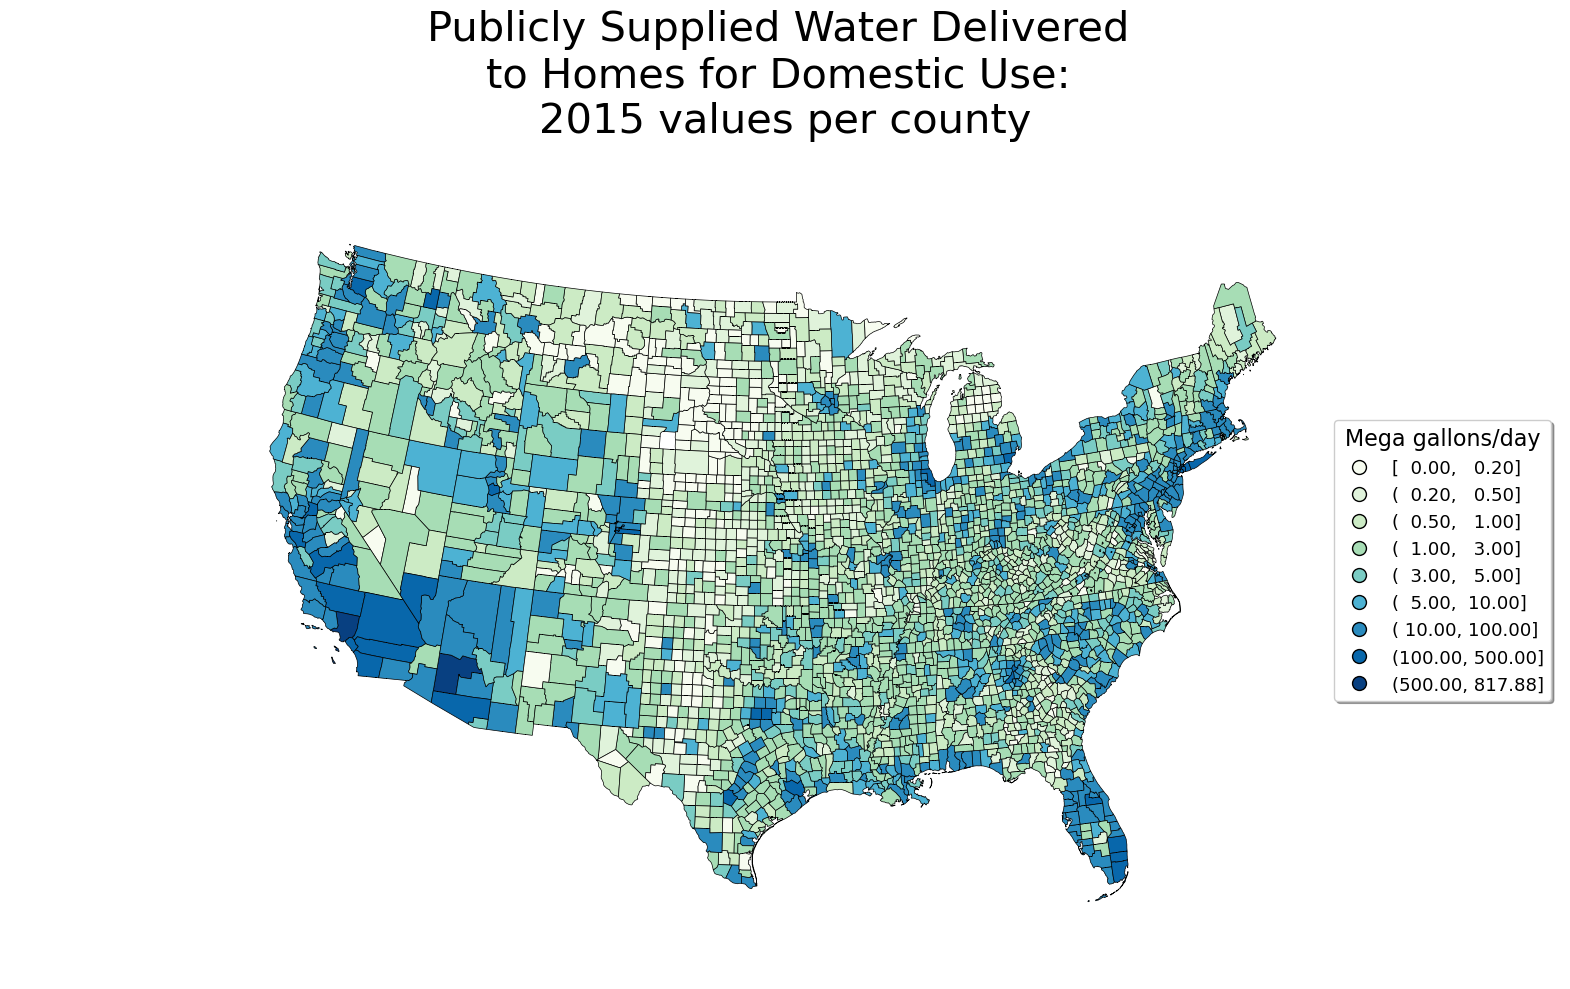

In [12]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df_full.dropna(subset =['DO-PSDel'])
viz_df['DO-PSDel'] = viz_df['DO-PSDel'].astype(float)
scheme = mc.UserDefined(viz_df['DO-PSDel'], bins=[.2, .5, 1, 3, 5, 10, 100, 500])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="DO-PSDel",
    scheme=scheme, 
    cmap='GnBu',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = True,
    legend_kwargs={'loc': 'center right', 'title': 'Mega gallons/day', 'shadow': True, 'title_fontsize': 16, 'fontsize':13}
)


count = 0
for txt in plot1.get_legend().texts:
    txt.set_text(mapping[count])
    count +=1
title = 'Publicly Supplied Water Delivered \nto Homes for Domestic Use: \n2015 values per county'
plot1.axes.set_title(title, fontsize=30)
plot1

C:\Users\mattp\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<GeoAxes: title={'center': 'Water Privately Withdrawn for Domestic Use: \n2015 values per county'}>

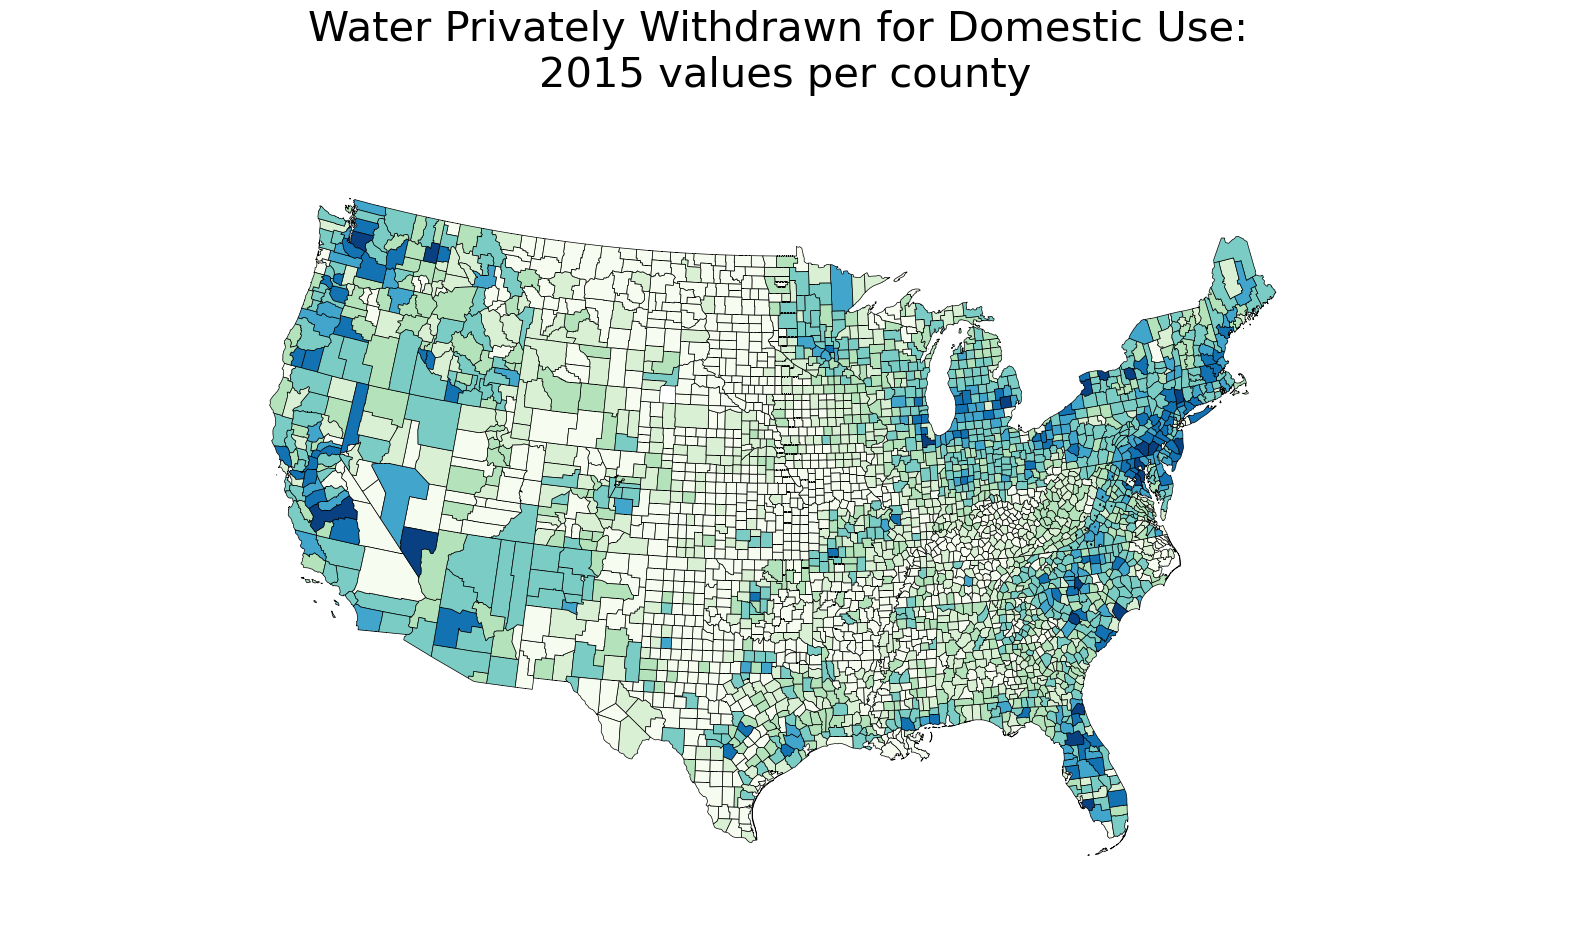

In [13]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df_full.dropna(subset =['DO-WFrTo'])
viz_df['DO-WFrTo'] = viz_df['DO-WFrTo'].astype(float)
scheme = mc.UserDefined(viz_df['DO-WFrTo'], bins=[.2, .5, 1, 3, 5, 10, 100, 500])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="DO-WFrTo",
    scheme=scheme, 
    cmap='GnBu',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = False,
)

title = 'Water Privately Withdrawn for Domestic Use: \n2015 values per county'
plot1.axes.set_title(title, fontsize=30)
plot1

Specific Domain Comparisons

C:\Users\mattp\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<GeoAxes: title={'center': 'Self-Supplied Freshwater Withdrawals: Irrigation \n2015 values per county'}>

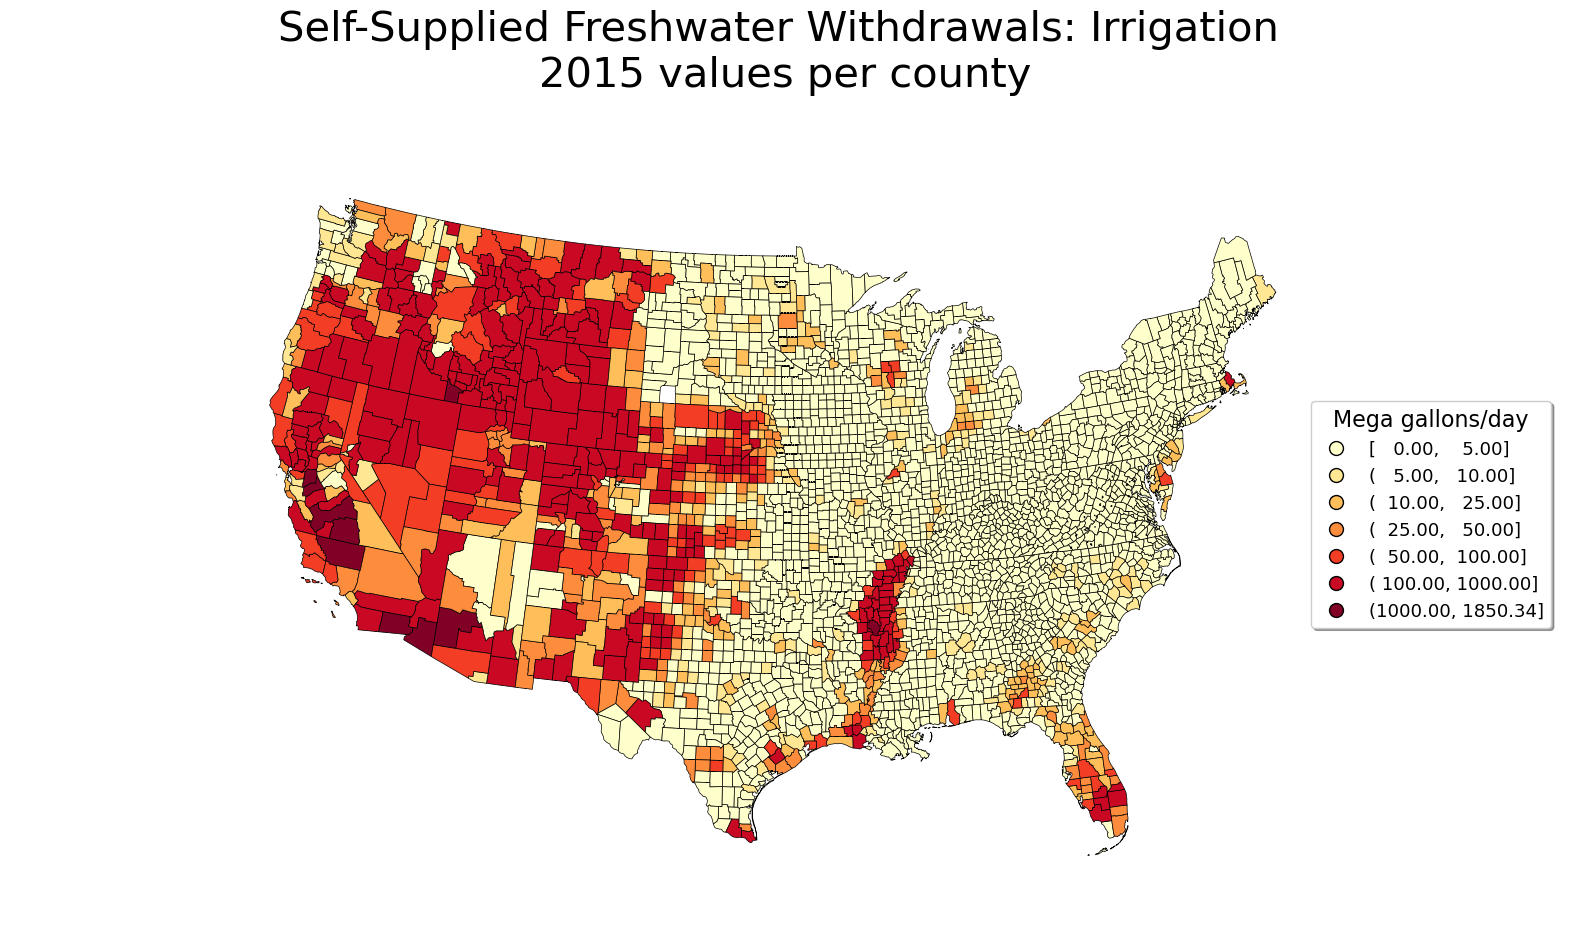

In [14]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df_full.dropna(subset =['IR-WFrTo'])
viz_df['IR-WFrTo'] = viz_df['IR-WFrTo'].astype(float)
scheme = mc.UserDefined(viz_df['IR-WFrTo'], bins=[5, 10, 25, 50, 100, 1000])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="IR-WFrTo",
    scheme=scheme, 
    cmap='YlOrRd',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = True,
    legend_kwargs={'loc': 'center right', 'title': 'Mega gallons/day', 'shadow': True, 'title_fontsize': 16, 'fontsize':13}
)


count = 0
for txt in plot1.get_legend().texts:
    txt.set_text(mapping[count])
    count +=1
title = 'Self-Supplied Freshwater Withdrawals: Irrigation \n2015 values per county'
plot1.axes.set_title(title, fontsize=30)
plot1

C:\Users\mattp\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<GeoAxes: title={'center': 'Self-Supplied Freshwater Withdrawals: Industry \n2015 values per county'}>

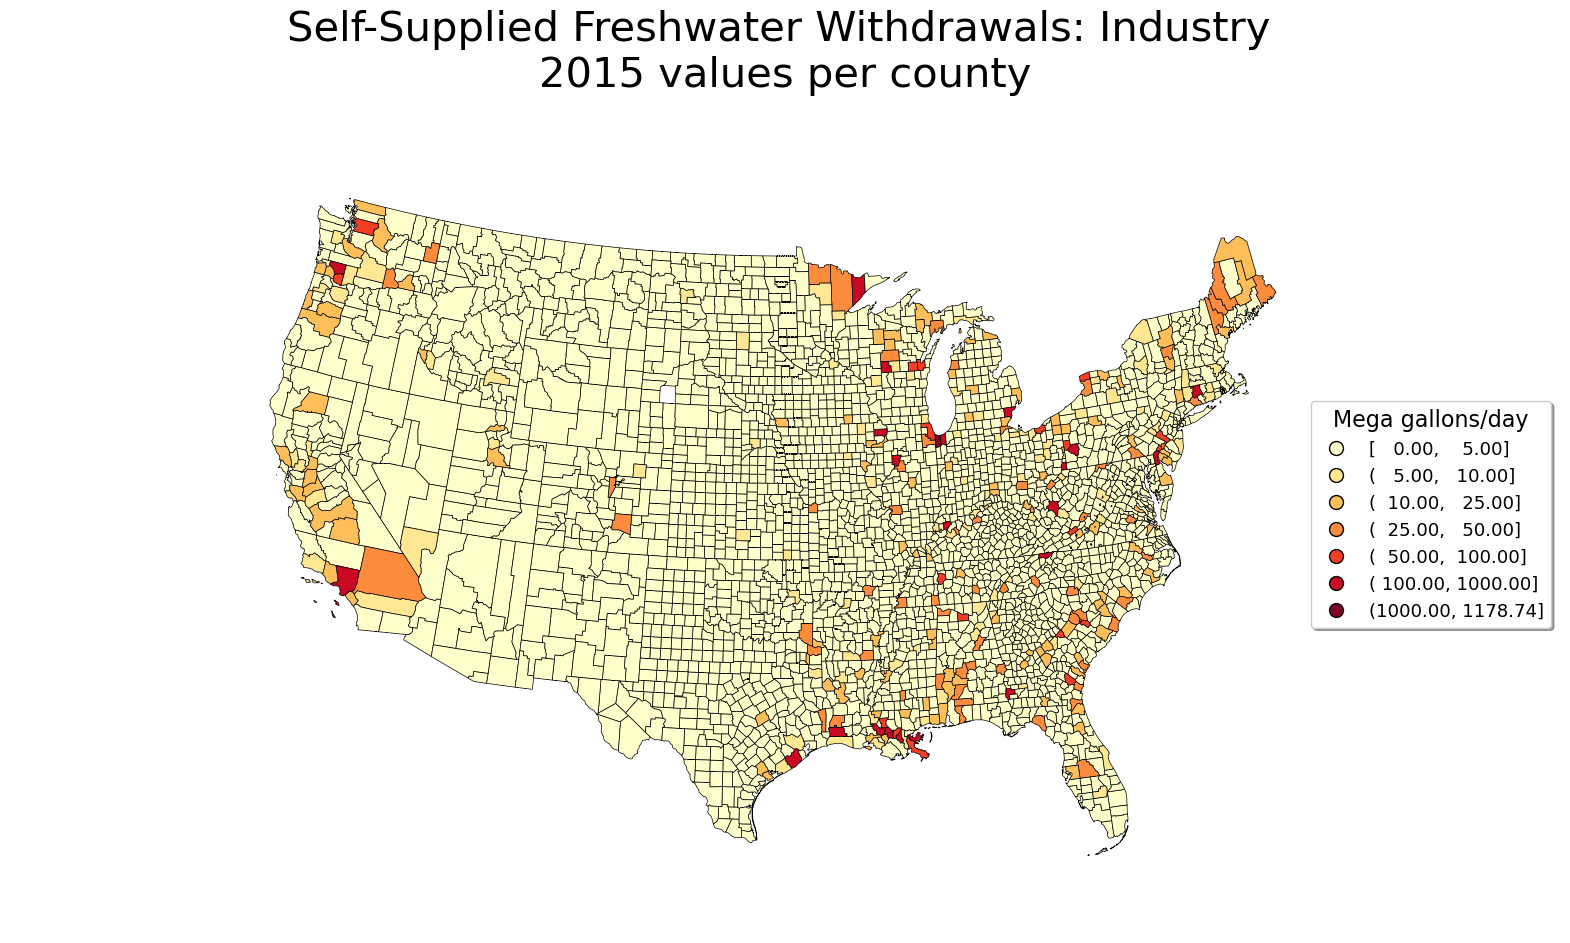

In [15]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df_full.dropna(subset =['IN-WFrTo'])
viz_df['IN-WFrTo'] = viz_df['IN-WFrTo'].astype(float)
scheme = mc.UserDefined(viz_df['IN-WFrTo'], bins=[5, 10, 25, 50, 100, 1000])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="IN-WFrTo",
    scheme=scheme, 
    cmap='YlOrRd',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = True,
    legend_kwargs={'loc': 'center right', 'title': 'Mega gallons/day', 'shadow': True, 'title_fontsize': 16, 'fontsize':13}
)


count = 0
for txt in plot1.get_legend().texts:
    txt.set_text(mapping[count])
    count +=1
title = 'Self-Supplied Freshwater Withdrawals: Industry \n2015 values per county'
plot1.axes.set_title(title, fontsize=30)
plot1

C:\Users\mattp\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<GeoAxes: title={'center': 'Freshwater Withdrawals: Public Supply \n2015 values per county'}>

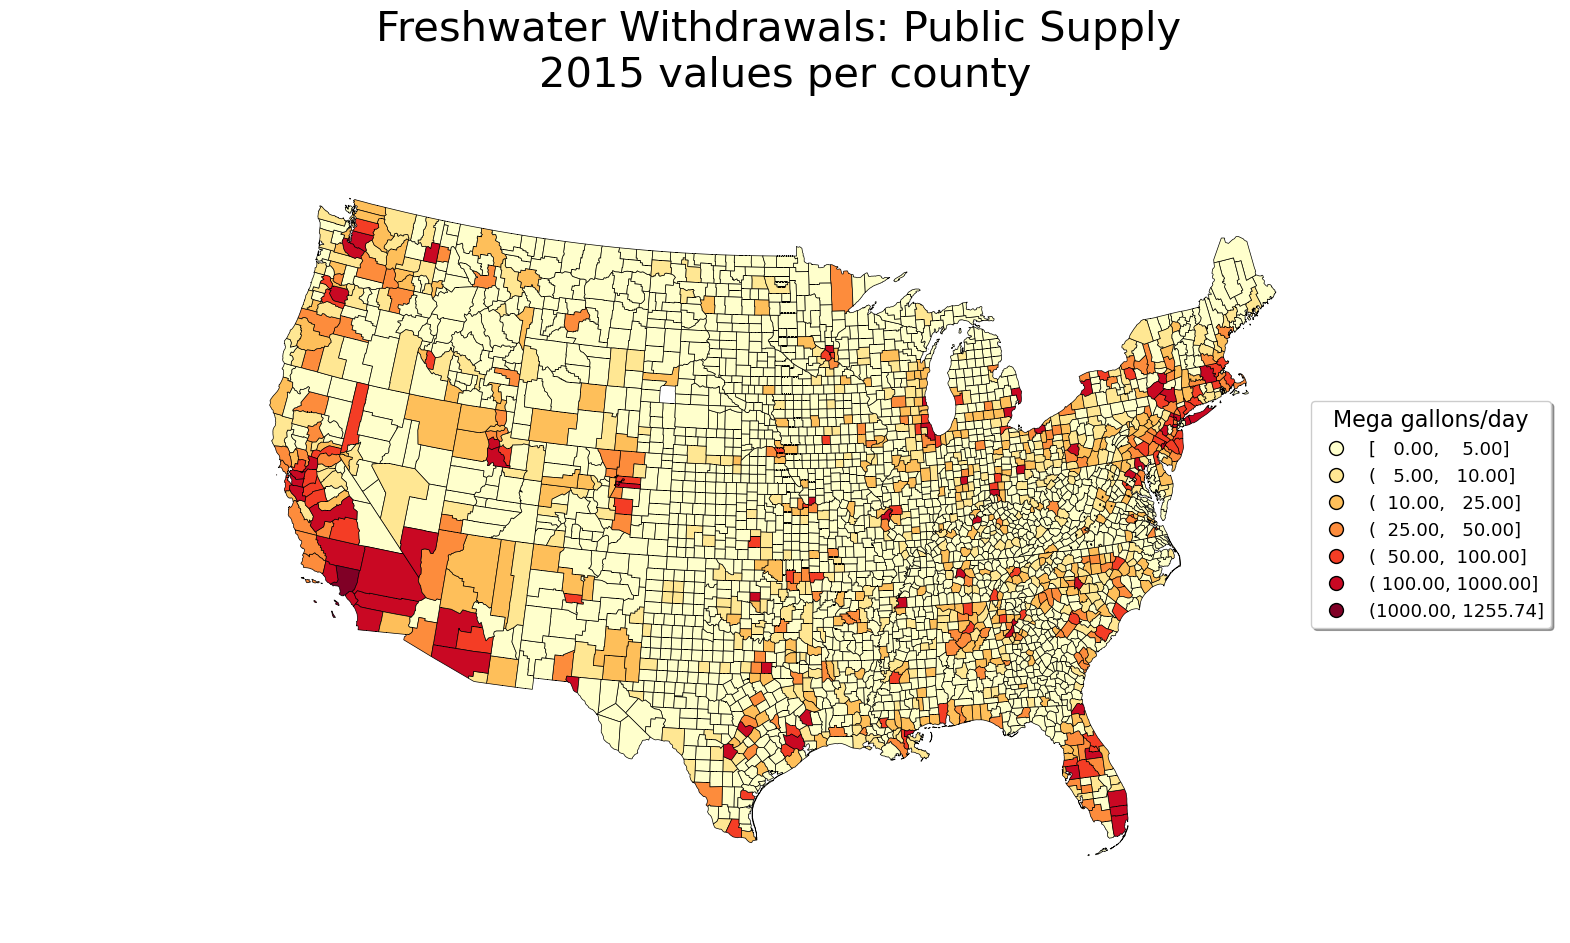

In [16]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df_full.dropna(subset =['PS-WFrTo'])
viz_df['PS-WFrTo'] = viz_df['PS-WFrTo'].astype(float)
scheme = mc.UserDefined(viz_df['PS-WFrTo'], bins=[5,10, 25, 50, 100, 1000])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="PS-WFrTo",
    scheme=scheme, 
    cmap='YlOrRd',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = True,
    legend_kwargs={'loc': 'center right', 'title': 'Mega gallons/day', 'shadow': True, 'title_fontsize': 16, 'fontsize':13}
)

count = 0
for txt in plot1.get_legend().texts:
    txt.set_text(mapping[count])
    count +=1
title = 'Freshwater Withdrawals: Public Supply \n2015 values per county'
plot1.axes.set_title(title, fontsize=30)
plot1

C:\Users\mattp\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<GeoAxes: title={'center': 'Self-Supplied Freshwater Withdrawals: Thermoelectric Power \n2015 values per county'}>

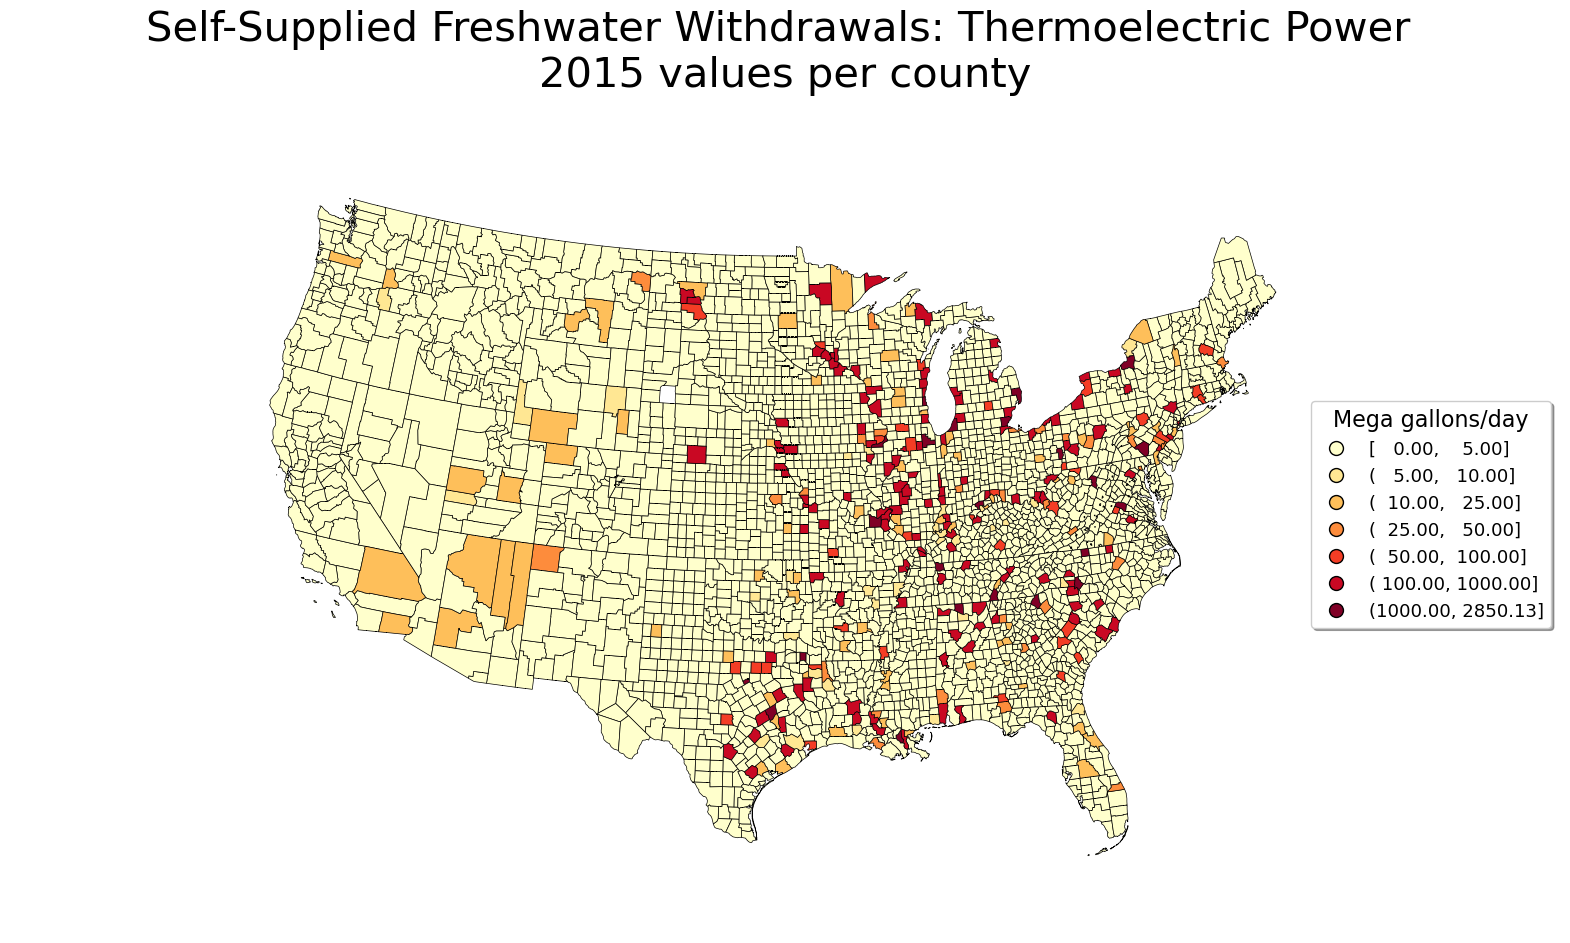

In [17]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df_full.dropna(subset =['PT-WFrTo'])
viz_df['PT-WFrTo'] = viz_df['PT-WFrTo'].astype(float)
scheme = mc.UserDefined(viz_df['PT-WFrTo'], bins=[5, 10, 25, 50, 100, 1000])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="PT-WFrTo",
    scheme=scheme, 
    cmap='YlOrRd',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = True,
    legend_kwargs={'loc': 'center right', 'title': 'Mega gallons/day', 'shadow': True, 'title_fontsize': 16, 'fontsize':13}
)


count = 0
for txt in plot1.get_legend().texts:
    txt.set_text(mapping[count])
    count +=1
title = 'Self-Supplied Freshwater Withdrawals: Thermoelectric Power \n2015 values per county'
plot1.axes.set_title(title, fontsize=30)
plot1

Mining fresh vs saline

C:\Users\mattp\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<GeoAxes: title={'center': 'Mining: Self-Supplied Freshwater Withdrawals\n2015 values per county'}>

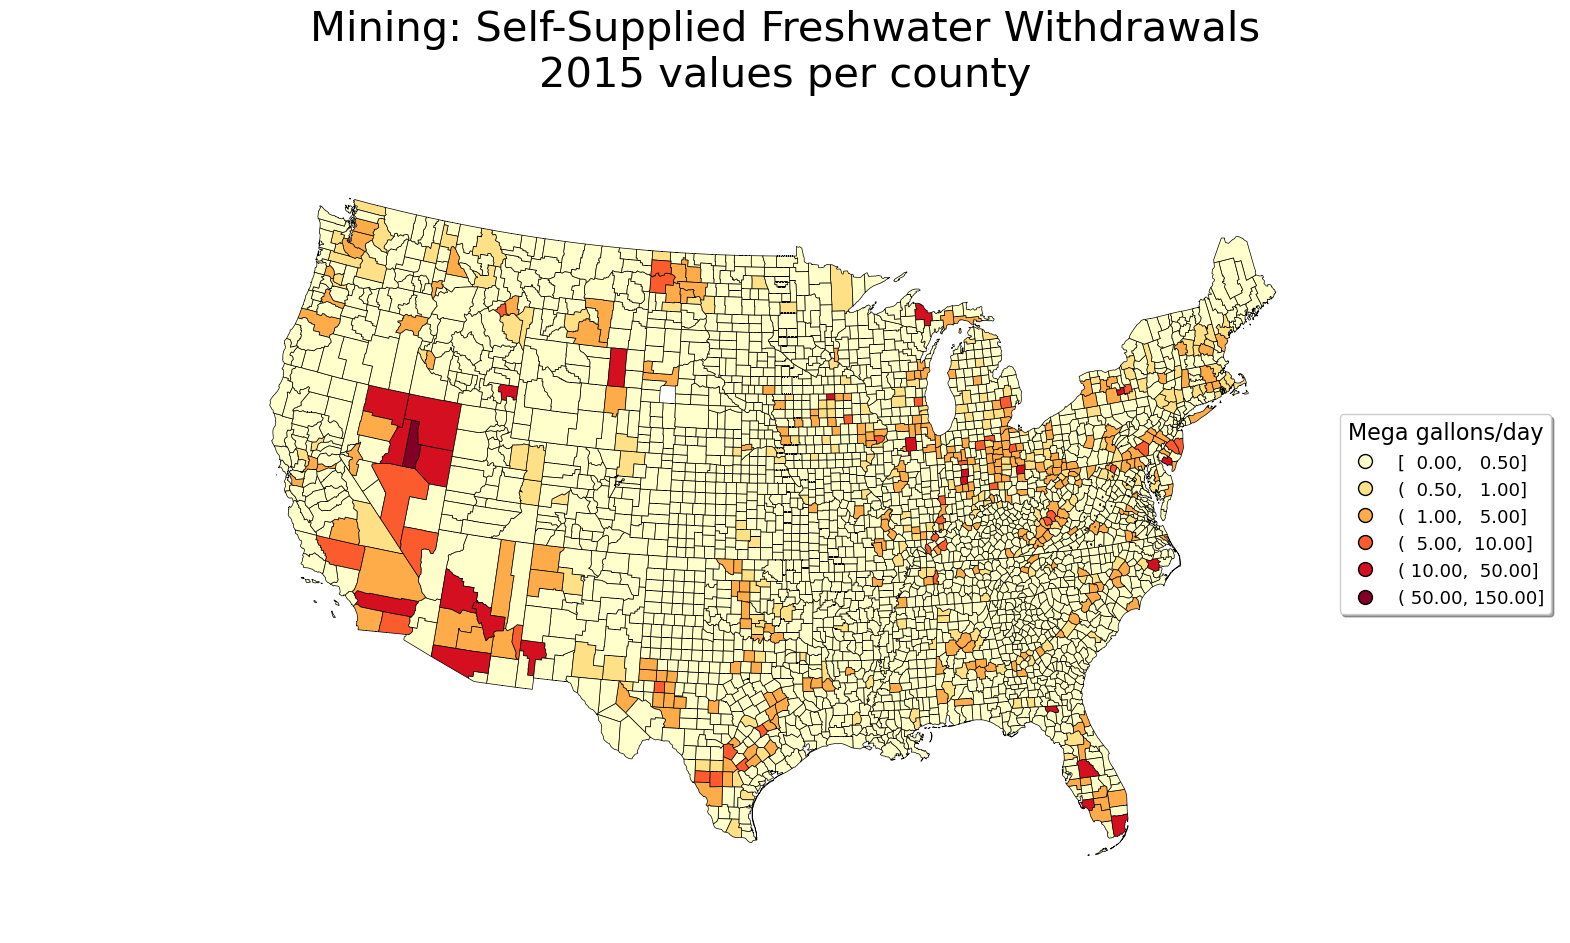

In [18]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df_full.dropna(subset =['MI-WFrTo'])
viz_df['MI-WFrTo'] = viz_df['MI-WFrTo'].astype(float)
scheme = mc.UserDefined(viz_df['MI-WFrTo'], bins=[.5, 1, 5, 10, 50, 150])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="MI-WFrTo",
    scheme=scheme, 
    cmap='YlOrRd',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = True,
    legend_kwargs={'loc': 'center right', 'title': 'Mega gallons/day', 'shadow': True, 'title_fontsize': 16, 'fontsize':13}
)


count = 0
for txt in plot1.get_legend().texts:
    txt.set_text(mapping[count])
    count +=1
title = 'Mining: Self-Supplied Freshwater Withdrawals\n2015 values per county'
plot1.axes.set_title(title, fontsize=30)
plot1

C:\Users\mattp\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<GeoAxes: title={'center': 'Mining: Self-Supplied Saline Water Withdrawals\n2015 values per county'}>

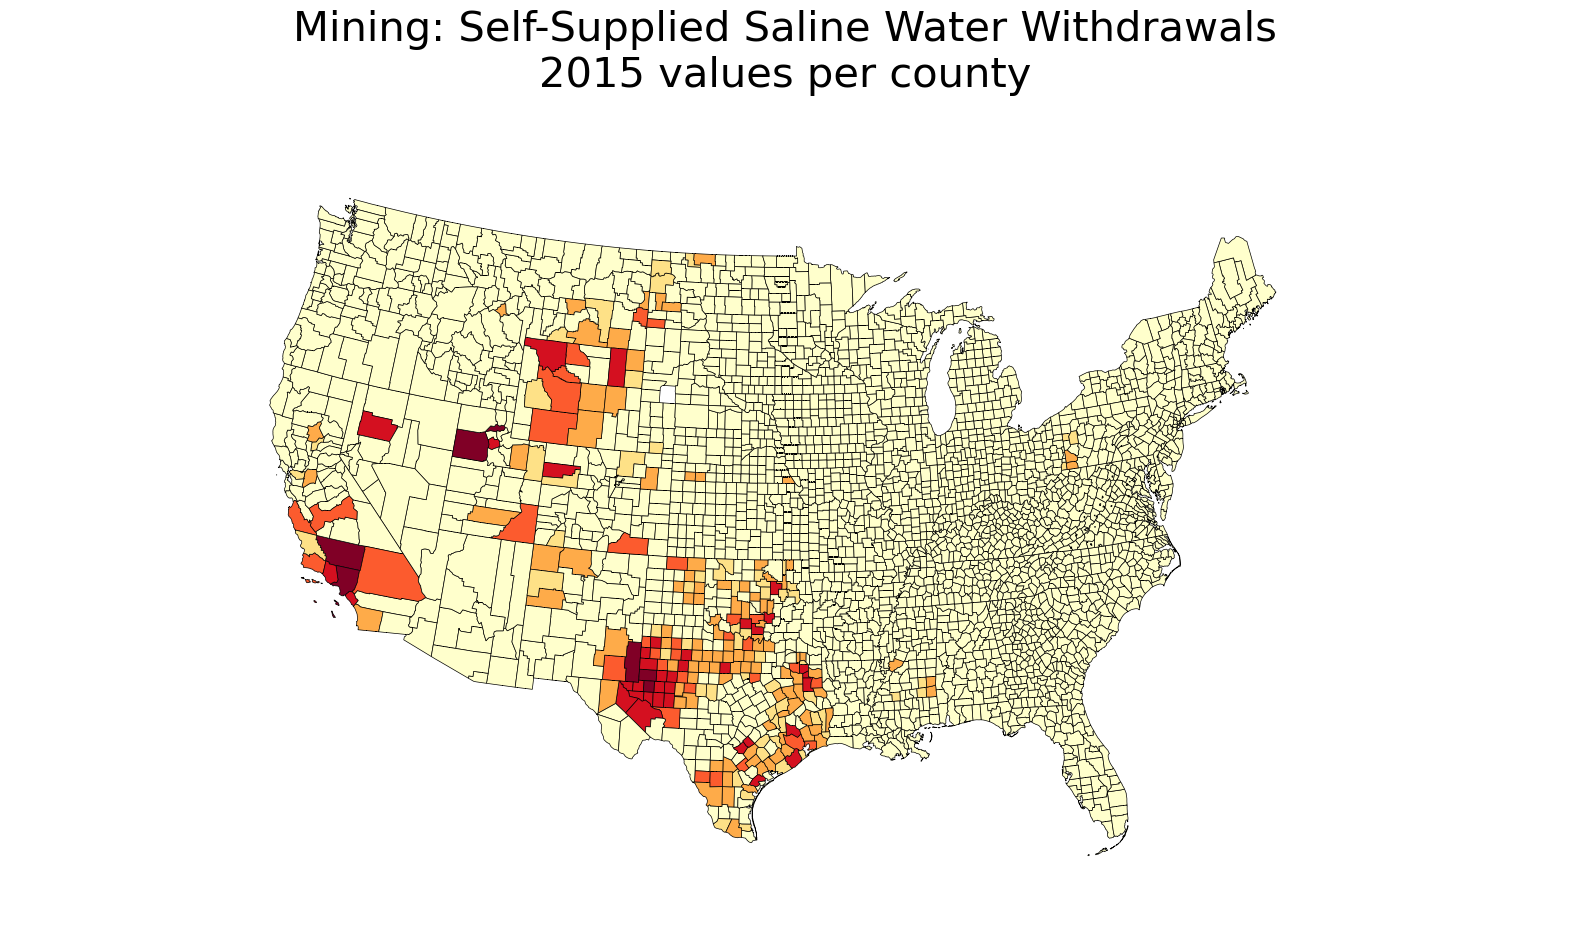

In [19]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
viz_df = viz_df_full.dropna(subset =['MI-WSaTo'])
viz_df['MI-WSaTo'] = viz_df['MI-WSaTo'].astype(float)
scheme = mc.UserDefined(viz_df['MI-WSaTo'], bins=[.5, 1, 5, 10, 50, 150])

scheme.get_legend_classes()
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="MI-WSaTo",
    scheme=scheme, 
    cmap='YlOrRd',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = False,
)

title = 'Mining: Self-Supplied Saline Water Withdrawals\n2015 values per county'
plot1.axes.set_title(title, fontsize=30)
plot1